In [1]:
import keras 
import numpy as np # linear algebra
import pandas as pd # data processing for CSV files
import tensorflow as tf # manipulating tensors
from gensim.models import KeyedVectors # library for importing pretrained WordEmbeddings
from tensorflow.keras.preprocessing.text import Tokenizer # used to tokenize text sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences # padding sequences to the same length
from sklearn.model_selection import train_test_split # splitting data into training and validation set 
from tensorflow.keras.models import Sequential # building sequential models like FF layers in the transformer encoder
from tensorflow.keras.layers import Dense,Embedding # used for parts of the transformer encoder
from tensorflow.keras import layers 
import re # Regex for standardizing text

In [3]:
df = pd.read_csv('Constraint_Train.csv')
df

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake


In [4]:
# renaming columns, shuffling them and removing unnecessary columns
df = df.sample(frac = 1)
df = df.drop('id', axis=1)
df = df.rename(columns={'tweet': 'text'})

# replacing the labels for integers, necessary for the loss function
df['label'] = df['label'].replace({'real':0, 'fake':1})

# limiting the data to the first 10,000 articles
df = df.iloc[:10000]
print("Number of fake Articles:", len(df.loc[df['label'] == 1]))
print("Number of real Articles:", len(df.loc[df['label'] == 0]))
df.head()

Number of fake Articles: 3060
Number of real Articles: 3360


,text,label
2223,A video of an Indonesian traditional market is...,1
819,New Video: Together we can stop the spread of ...,0
1349,229 new cases of #COVID19; Lagos-90 Katsina-27...,0
6351,WHO backtracked and now argues that all econom...,1
1372,Sir Patrick Vallance has said a #COVID19 vacci...,0


In [5]:
# iterating over the messages and standardizing them with case conversion, removing numbers, punctuation and white space
new_sentence = []
for sentence in df['text']:
    norm_sentence = sentence.lower() # removing capital letters
    norm_sentence = re.sub(r'\d+','',norm_sentence) # \d+ removing one or more digits [0-9]
    norm_sentence = re.sub(r'[^\w\s]','', norm_sentence) # removing all characters that are not alphaNumeric oder whitespace e.g. tab or space
    norm_sentence = norm_sentence.strip() # removing spaces at the beginning and end of a sentence e.g.   "    spam    "  -> "spam"
    norm_sentence = ' '.join(norm_sentence.split()[15:]) # discarding the first 15 words of each sentence 
    new_sentence.append(norm_sentence)
df['New_Text'] = new_sentence # adding new column with the standardized message
df.head()

,text,label,New_Text
2223,A video of an Indonesian traditional market is...,1,
819,New Video: Together we can stop the spread of ...,0,hygiene and avoiding nonessential travel watch...
1349,229 new cases of #COVID19; Lagos-90 Katsina-27...,0,gombe osun anambra bayelsa cases of covid in n...
6351,WHO backtracked and now argues that all econom...,1,
1372,Sir Patrick Vallance has said a #COVID19 vacci...,0,first half of get the latest on coronavirus ht...


In [6]:
train_x,test_x,train_y,test_y=train_test_split(df['New_Text'],df['label'],test_size=0.3,random_state=42) # splitting data into train and test data 70%-30%

In [7]:
tokenizer = Tokenizer() # used to tokenize our messages

tokenizer.fit_on_texts(train_x) # updates internal vocabulary. Each unique word in train_x gets assigned to a specific integer, so to say an ID. For Example {the,1}, {news,2}, {evening, 3}

vocab_size=len(tokenizer.word_index)+1 #  vocab_size contains the number of unique words in train_x

train_x_seq=tokenizer.texts_to_sequences(train_x) # converting the tokens of a text corpus into a sequence of integers, e.g "the evening news" -> [1, 3, 2]
test_x_seq=tokenizer.texts_to_sequences(test_x)

In [8]:
# determine the number of news articles with more than 500 words
nos = np.array([len(x) for x in train_x_seq])
print(len(nos[nos>500]))
maxlen = 500

1


In [9]:
# setting the maximum length of each sequence to be 500. Adding 0's to the sequences with less than 500 words until the length of each sequence is 500
train_x_pad=pad_sequences(train_x_seq,maxlen=maxlen,padding='post')
test_x_pad=pad_sequences(test_x_seq,maxlen=maxlen,padding='post')

In [10]:
embeddings=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True) # loading pretrained WordEmbeddings

In [11]:
# Building the weight matrix 
embeddings_mat=np.zeros((vocab_size,300))

for w,wid in tokenizer.word_index.items():
    if w in embeddings:
        embeddings_mat[wid]=embeddings[w] # if the word w has a pretrained embedding, the embedding gets stored in the row according to the word-id

In [12]:
# Building the transformer encoder composed of one MultiHeadAttention layer and one Sequential FF layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim 
        self.dense_dim = dense_dim 
        self.num_heads = num_heads 
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation="relu"),
         layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    
    def call(self, inputs, mask=None): 
        if mask is not None: 
            mask = mask[:, tf.newaxis, :] 
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [13]:
# building the model:

# defining hyperparameters
embed_dim = 300
dense_dim = 32
num_heads = 4

# inputs first pass the embedding layer, which uses the pretrained embedding matrix as weights, then one transformer encoder, afterwards MaxPooling and one dense layer for classification 
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size,embed_dim, weights = [embeddings_mat], input_length = maxlen, trainable=False)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# setting optimizer, loss function and metrics
model.compile(optimizer="SGD",
 loss="binary_crossentropy",
 metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         2600100   
                                                                 
 transformer_encoder (Transf  (None, None, 300)        1464632   
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 4,065,033
Trainable params: 1,464,933
Non-train

In [14]:
#train the model in batches of 4
my_model=model.fit(x=train_x_pad, y=train_y, batch_size=4, epochs=20, validation_data=(test_x_pad,test_y))


Epoch 1/20
1124/1124 [==============================] - 595s 529ms/step - loss: 0.7239 - accuracy: 0.6393 - val_loss: 0.9684 - val_accuracy: 0.4673
Epoch 2/20
1124/1124 [==============================] - 596s 530ms/step - loss: 0.6294 - accuracy: 0.6749 - val_loss: 0.5362 - val_accuracy: 0.7279
Epoch 3/20
1124/1124 [==============================] - 593s 528ms/step - loss: 0.5882 - accuracy: 0.7101 - val_loss: 0.7711 - val_accuracy: 0.5343
Epoch 4/20
1124/1124 [==============================] - 586s 521ms/step - loss: 0.5627 - accuracy: 0.7267 - val_loss: 0.6714 - val_accuracy: 0.6843
Epoch 5/20
1124/1124 [==============================] - 585s 520ms/step - loss: 0.5352 - accuracy: 0.7425 - val_loss: 0.4707 - val_accuracy: 0.8032
Epoch 6/20
1124/1124 [==============================] - 588s 523ms/step - loss: 0.5184 - accuracy: 0.7583 - val_loss: 0.6280 - val_accuracy: 0.7290
Epoch 7/20
1124/1124 [==============================] - 646s 575ms/step - loss: 0.4880 - accuracy: 0.7786 - val_

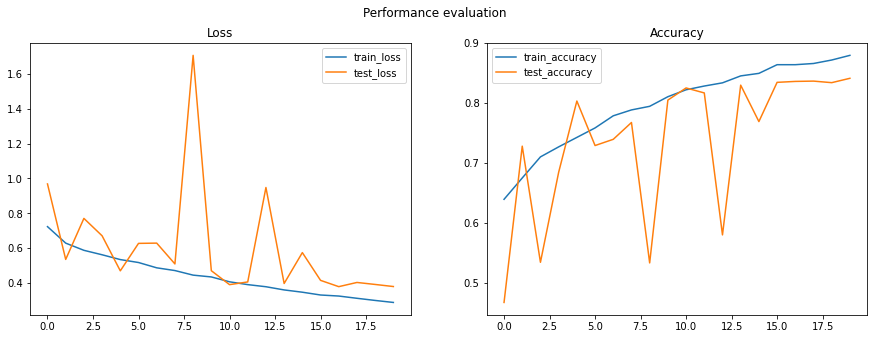

In [15]:
#plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(my_model.history['loss'],label='train_loss')
plt.plot(my_model.history['val_loss'],label='test_loss')
plt.title("Loss")
plt.legend()
plt.suptitle("Performance evaluation")

plt.subplot(122)
plt.plot(my_model.history['accuracy'],label='train_accuracy')
plt.plot(my_model.history['val_accuracy'],label='test_accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

In [6]:
df1 = pd.read_csv('Constraint_Train.csv')
df1 = df1.drop('id', axis=1)
df1 = df1.rename(columns={'tweet': 'text'})
df1['label'] = df1['label'].replace({'real':0, 'fake':1})

fake = pd.read_csv('Fake.csv', delimiter=',',encoding='latin-1')
real = pd.read_csv('True.csv',delimiter=',',encoding='latin-1')
fake['label'] = 'fake'
real['label'] = 'real'
df2 = pd.concat([fake, real], axis=0)
df2 = df2.sample(frac = 1)
df2 = df2.drop('subject', axis=1)
df2 = df2.drop('date', axis=1)
df2 = df2.drop('title', axis=1)
df2['label'] = df2['label'].replace({'real':0, 'fake':1})

df = pd.concat([df1, df2], axis=0)
df = df.sample(frac = 1)
df = df.iloc[:10000]

In [7]:
df

,text,label
9670,President Trump hit back at Senator John McCai...,1
15151,WOW! This is the kind of woman the Republican ...,1
11146,Here s the original post by the Washington Pos...,1
14566,LOL! You ll want to share this with everyone D...,1
11568,RIYADH (Reuters) - Saudi Arabia announced on F...,0
...,...,...
2726,The State Department has a special cable desig...,1
8889,Republican front runner Donald Trump has revea...,1
3490,If you are licensed to carry a concealed weapo...,1
9879,The hateful Hollywood crowd just couldn t help...,1


In [8]:
# iterating over the messages and standardizing them with case conversion, removing numbers, punctuation and white space
new_sentence = []
for sentence in df['text']:
    norm_sentence = sentence.lower() # removing capital letters
    norm_sentence = re.sub(r'\d+','',norm_sentence) # \d+ removing one or more digits [0-9]
    norm_sentence = re.sub(r'[^\w\s]','', norm_sentence) # removing all characters that are not alphaNumeric oder whitespace e.g. tab or space
    norm_sentence = norm_sentence.strip() # removing spaces at the beginning and end of a sentence e.g.   "    spam    "  -> "spam"
    norm_sentence = ' '.join(norm_sentence.split()[15:]) # discarding the first 15 words of each sentence 
    new_sentence.append(norm_sentence)
df['New_Text'] = new_sentence # adding new column with the standardized message
df.head()

,text,label,New_Text
9670,President Trump hit back at Senator John McCai...,1,it clear that trump isn t playing around with ...
15151,WOW! This is the kind of woman the Republican ...,1,for a long time no more mrs nice guy carly tak...
11146,Here s the original post by the Washington Pos...,1,share an image of putin as a gay clown httpstc...
14566,LOL! You ll want to share this with everyone D...,1,lunch medical marijuana and bus ride to the co...
11568,RIYADH (Reuters) - Saudi Arabia announced on F...,0,united kingdom would once again be allowed to ...


In [9]:
train_x,test_x,train_y,test_y=train_test_split(df['New_Text'],df['label'],test_size=0.3,random_state=42) # splitting data into train and test data 70%-30%

In [10]:
tokenizer = Tokenizer() # used to tokenize our messages

tokenizer.fit_on_texts(train_x) # updates internal vocabulary. Each unique word in train_x gets assigned to a specific integer, so to say an ID. For Example {the,1}, {news,2}, {evening, 3}

vocab_size=len(tokenizer.word_index)+1 #  vocab_size contains the number of unique words in train_x

train_x_seq=tokenizer.texts_to_sequences(train_x) # converting the tokens of a text corpus into a sequence of integers, e.g "the evening news" -> [1, 3, 2]
test_x_seq=tokenizer.texts_to_sequences(test_x)

In [11]:
# determine the number of news articles with more than 500 words
nos = np.array([len(x) for x in train_x_seq])
print(len(nos[nos>500]))
maxlen = 500

1430


In [12]:
# setting the maximum length of each sequence to be 500. Adding 0's to the sequences with less than 500 words until the length of each sequence is 500
train_x_pad=pad_sequences(train_x_seq,maxlen=maxlen,padding='post')
test_x_pad=pad_sequences(test_x_seq,maxlen=maxlen,padding='post')

In [13]:
embeddings=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True) # loading pretrained WordEmbeddings

In [14]:
# Building the weight matrix 
embeddings_mat=np.zeros((vocab_size,300))

for w,wid in tokenizer.word_index.items():
    if w in embeddings:
        embeddings_mat[wid]=embeddings[w] # if the word w has a pretrained embedding, the embedding gets stored in the row according to the word-id

In [15]:
# Building the transformer encoder composed of one MultiHeadAttention layer and one Sequential FF layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim 
        self.dense_dim = dense_dim 
        self.num_heads = num_heads 
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation="relu"),
         layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    
    def call(self, inputs, mask=None): 
        if mask is not None: 
            mask = mask[:, tf.newaxis, :] 
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [16]:
# building the model:

# defining hyperparameters
embed_dim = 300
dense_dim = 32
num_heads = 4

# inputs first pass the embedding layer, which uses the pretrained embedding matrix as weights, then one transformer encoder, afterwards MaxPooling and one dense layer for classification 
inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size,embed_dim, weights = [embeddings_mat], input_length = maxlen, trainable=False)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# setting optimizer, loss function and metrics
model.compile(optimizer="SGD",
 loss="binary_crossentropy",
 metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         23112300  
                                                                 
 transformer_encoder (Transf  (None, None, 300)        1464632   
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 24,577,233
Trainable params: 1,464,933
Non-trai

In [17]:
#train the model in batches of 4
my_model=model.fit(x=train_x_pad, y=train_y, batch_size=4, epochs=20, validation_data=(test_x_pad,test_y))

Epoch 1/20
1750/1750 [==============================] - 938s 535ms/step - loss: 0.5320 - accuracy: 0.7729 - val_loss: 0.7022 - val_accuracy: 0.6953
Epoch 2/20
1750/1750 [==============================] - 916s 523ms/step - loss: 0.2369 - accuracy: 0.9063 - val_loss: 0.1750 - val_accuracy: 0.9287
Epoch 3/20
1750/1750 [==============================] - 911s 521ms/step - loss: 0.1983 - accuracy: 0.9207 - val_loss: 0.2550 - val_accuracy: 0.9027
Epoch 4/20
1750/1750 [==============================] - 920s 526ms/step - loss: 0.1739 - accuracy: 0.9289 - val_loss: 0.1619 - val_accuracy: 0.9353
Epoch 5/20
1750/1750 [==============================] - 13050s 7s/step - loss: 0.1538 - accuracy: 0.9399 - val_loss: 0.1718 - val_accuracy: 0.9390
Epoch 6/20
1750/1750 [==============================] - 8782s 5s/step - loss: 0.1315 - accuracy: 0.9497 - val_loss: 0.1571 - val_accuracy: 0.9383
Epoch 7/20
1750/1750 [==============================] - 4621s 3s/step - loss: 0.1115 - accuracy: 0.9563 - val_loss:

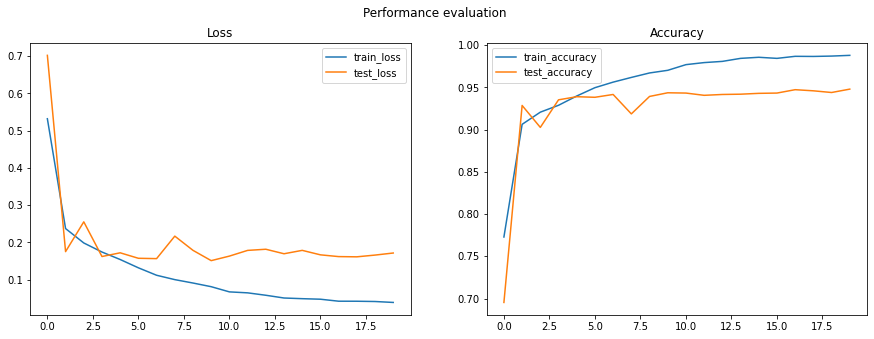

In [18]:
#plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(my_model.history['loss'],label='train_loss')
plt.plot(my_model.history['val_loss'],label='test_loss')
plt.title("Loss")
plt.legend()
plt.suptitle("Performance evaluation")

plt.subplot(122)
plt.plot(my_model.history['accuracy'],label='train_accuracy')
plt.plot(my_model.history['val_accuracy'],label='test_accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()